In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import grad

import models

In [2]:
data = sio.loadmat("data.mat")
res = data["res"].T
doses = data["doses"].T
Zr = data["cases"].T
Dr = data["deaths"].T
A = data["hospitalized"].T
t = data["time"].T

Zr[Zr <= 0] = 0 # 1e-8
Dr[Dr <= 0] = 0 #1e-8
A[A <= 0] = 0 #1e-8

Text(0.5, 1.0, 'Cases')

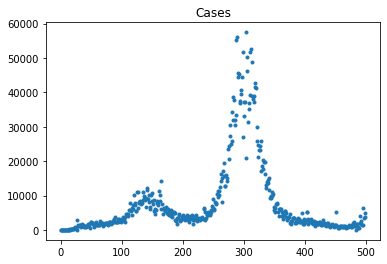

In [3]:
plt.plot(t[:500], Zr[:500], '.')
plt.title("Cases")

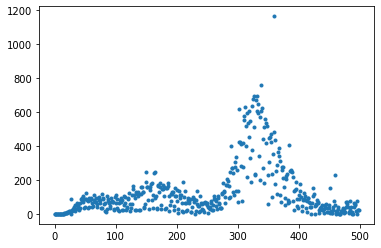

In [4]:
plt.plot(t[:500], Dr[:500], '.')

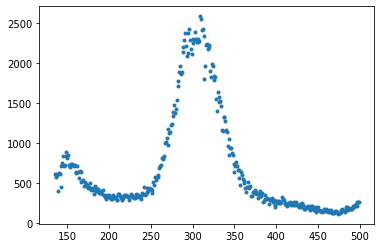

In [5]:
plt.plot(t[:500], A[:500], '.')

In [6]:
K = 400
res = res[:K]
doses = doses[:K]
Zr_train = Zr[:K]
Dr_train = Dr[:K]
A_train = A[:K]

t_Zr = t[:K]
t_Dr = t[:K]
t_A = t[:K]

t_ode = t[:K+100]
t_test = t_ode
Zr_test = Zr[:K+100]
Dr_test = Dr[:K+100]
A_test = A[:K+100]
t_A_test = t_test[~np.isnan(A_test)].reshape([-1, 1])

# preprocess nan
doses[np.isnan(doses)] = 0
t_A = t_A[~np.isnan(A_train)].reshape([-1, 1])
A_train = A_train[~np.isnan(A_train)].reshape([-1, 1])
A_test = A_test[~np.isnan(A_test)].reshape([-1, 1])


N = 39512223.0
eta = 1/4
gamma = 1/4
gamma_dw = 1/10
gamma_zw = 1
gamma_h = 1/10
rho = 0.5

In [7]:
# prepare data
t_ode = torch.tensor(t_ode, dtype=torch.float32, requires_grad=True)
t0 = torch.tensor([[0]], dtype=torch.float32)
t_Zr = torch.tensor(t_Zr, dtype=torch.float32)
t_Dr = torch.tensor(t_Dr, dtype=torch.float32)
t_A = torch.tensor(t_A, dtype=torch.float32)

Zr0 = torch.tensor([[0]], dtype=torch.float32)
Dr0 = torch.tensor([[0]], dtype=torch.float32)
A0 = torch.tensor([[0]], dtype=torch.float32)
Zr_train = torch.tensor(Zr_train, dtype=torch.float32)
Dr_train = torch.tensor(Dr_train, dtype=torch.float32)
A_train = torch.tensor(A_train, dtype=torch.float32)

In [8]:
# prepare model
u = models.NN(
    layers=[1, 50, 50, 50, 50, 50, 9],
    activation=torch.tanh,
    input_transform=lambda t: t/500,
    output_transform=torch.exp,
)
L0 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True)
log_beta = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
logit_p_h = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
logit_p_d = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)

parameters = list(u.parameters()) + [L0, log_beta, logit_p_h, logit_p_d]
opt = torch.optim.Adam(parameters, lr=0.001)

In [9]:
weights = torch.tensor([1, 1e-10, 1, 1, 1], dtype=torch.float32)

In [10]:
loss1 = []
loss2 = []
loss3 = []
loss4 = []
loss5 = []
for it in range(10000):
    beta = torch.clip(torch.exp(log_beta), max=1000)
    p_h = torch.sigmoid(logit_p_h)
    p_d = torch.sigmoid(logit_p_d)
    args = [
        beta,
        p_h,
        N, eta, gamma, gamma_dw, gamma_zw, gamma_h,
        p_d,
        rho,
    ]
    Y0 = eta * L0 / gamma
    Z0 = (p_h + rho * (1 - p_h)) * gamma * Y0 / gamma_zw
    H0 = p_h * gamma * Y0 / gamma_h
    D0 = p_d * gamma_h * H0 / gamma_dw
    X0 = torch.clip(N - L0 - Y0 - H0 - D0, min=N/10)
    u0 = torch.concat([X0, L0, Y0, Z0, Zr0, H0, A0, D0, Dr0], dim=-1)
    
    losses = models.loss_function(
        u, 
        t_ode, 
        t0,
        u0,
        t_Zr, Zr_train, 
        t_Dr, Dr_train, 
        t_A, A_train, 
        args,
    )
    loss_value = torch.sum(weights * torch.stack(losses))
    opt.zero_grad()
    loss_value.backward()
    opt.step()
    loss1 += [losses[0].detach().cpu().numpy()]
    loss2 += [losses[1].detach().cpu().numpy()]
    loss3 += [losses[2].detach().cpu().numpy()]
    loss4 += [losses[3].detach().cpu().numpy()]
    loss5 += [losses[4].detach().cpu().numpy()]
    if it % 100 == 0:
        print(it, loss_value.detach().cpu().numpy())

0 232425280.0
100 144776500.0
200 144083310.0
300 144082600.0
400 92715330.0
500 88771720.0
600 88528350.0
700 88307864.0
800 88156580.0
900 87085540.0
1000 25064180.0
1100 10259705.0
1200 9986220.0
1300 9786473.0
1400 9653384.0
1500 9560749.0
1600 9493154.0
1700 9442770.0
1800 9404194.0
1900 9373343.0
2000 9347197.0
2100 9323686.0
2200 9391874.0
2300 9279496.0
2400 9281248.0
2500 9237757.0
2600 9226032.0
2700 9207596.0
2800 9183771.0
2900 9219715.0
3000 9156702.0
3100 9158390.0
3200 9156797.0
3300 9115996.0
3400 9122586.0
3500 9086646.0
3600 9098114.0
3700 9048690.0
3800 9029403.0
3900 9032138.0
4000 8983707.0
4100 8654994.0
4200 8010706.0
4300 7712142.0
4400 7655474.5
4500 7662709.0
4600 7597358.5
4700 7506197.0
4800 7488744.5
4900 11325707.0
5000 7342847.0
5100 7247090.5
5200 7156336.5
5300 7067471.5
5400 6991896.0
5500 8623844.0
5600 6913246.5
5700 6885714.0
5800 6864580.0
5900 6846865.0
6000 6831172.0
6100 7031552.0
6200 6815269.5
6300 6801345.0
6400 6788318.5
6500 6775459.0
6600 

In [11]:
u_pred = u.forward(t_ode).detach().cpu()

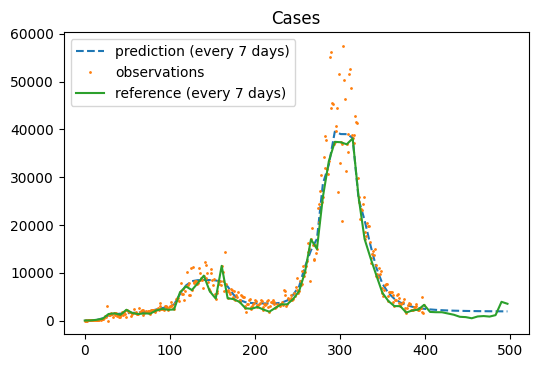

In [27]:
plt.figure(dpi=100)
plt.plot(t_ode.detach().cpu()[::7], u_pred[:, 4:5][::7], '--', label="prediction (every 7 days)")
plt.plot(t_Zr, Zr_train, 'o', markersize=1, label="observations")
plt.plot(t_ode.detach().cpu()[::7], Zr_test[::7], label="reference (every 7 days)")
plt.title("Cases")
plt.legend()

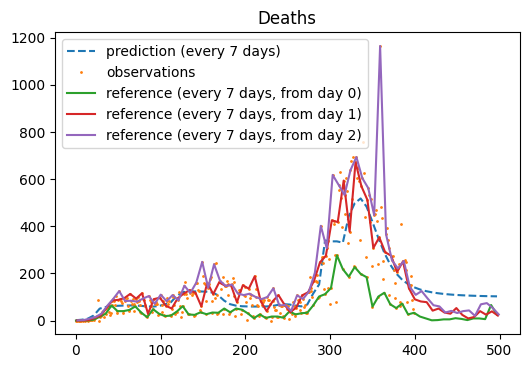

In [41]:
plt.figure(dpi=100)
plt.plot(t_ode.detach().cpu()[::7], u_pred[:, 8:9][::7], '--', label="prediction (every 7 days)")
plt.plot(t_Dr, Dr_train, 'o', markersize=1, label="observations")
plt.plot(t_ode.detach().cpu()[::7], Dr_test[::7], label="reference (every 7 days, from day 0)")
plt.plot(t_ode.detach().cpu()[1::7], Dr_test[1::7], label="reference (every 7 days, from day 1)")
plt.plot(t_ode.detach().cpu()[2::7], Dr_test[2::7], label="reference (every 7 days, from day 2)")
plt.title("Deaths")
plt.legend()

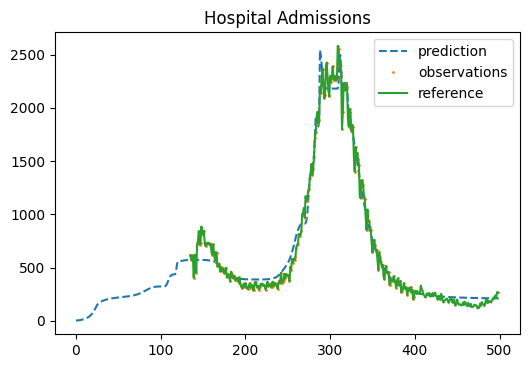

In [31]:
plt.figure(dpi=100)
plt.plot(t_ode.detach().cpu(), u_pred[:, 6:7], '--', label="prediction")
plt.plot(t_A, A_train, 'o', markersize=1, label="observations")
plt.plot(t_A_test, A_test, label="reference")
plt.title("Hospital Admissions")
plt.legend()
plt.show()

Text(0.5, 1.0, 'A loss')

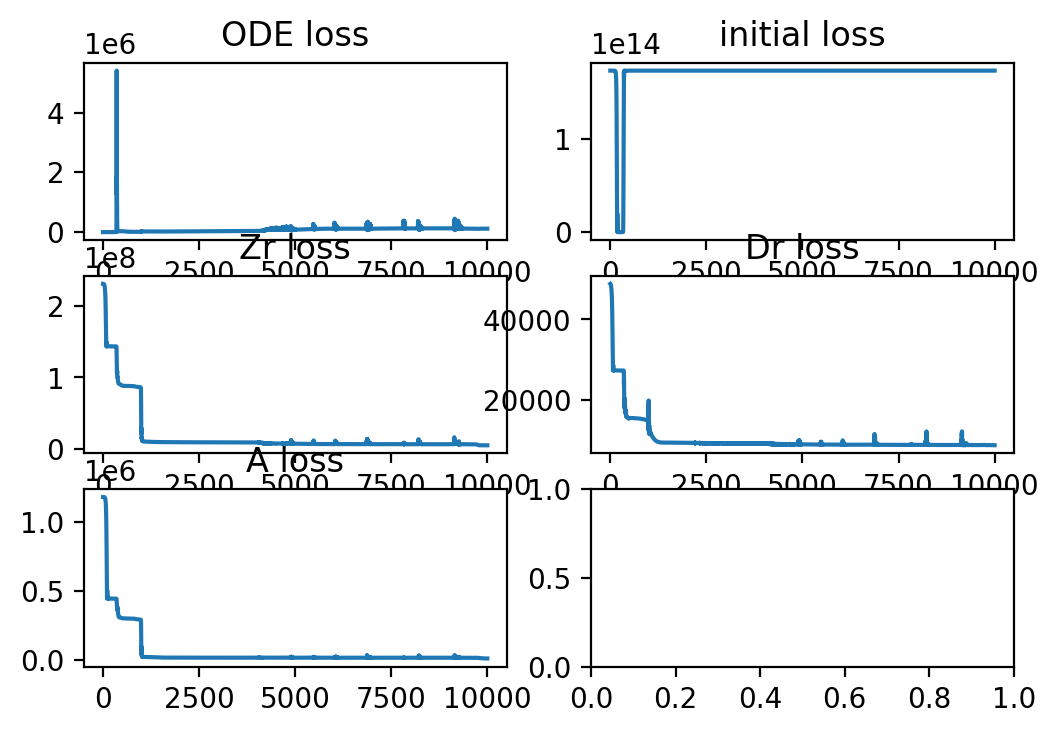

In [16]:
# fig = plt.figure()
fig, axes = plt.subplots(3, 2, dpi=200)
axes[0, 0].plot(loss1)
axes[0, 0].set_title("ODE loss")
axes[0, 1].plot(loss2)
axes[0, 1].set_title("initial loss")
axes[1, 0].plot(loss3)
axes[1, 0].set_title("Zr loss")
axes[1, 1].plot(loss4)
axes[1, 1].set_title("Dr loss")
axes[2, 0].plot(loss5)
axes[2, 0].set_title("A loss")